imports

In [1]:
!pip install tensorflow
!pip install tensorflow_probability
!pip install -U "tensorflow-probability[tf]"


import tensorflow as tf
import pandas as pd
import tensorflow_probability as tfp
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, Model

2025-10-02 12:26:18.464666: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-02 12:26:18.565091: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-10-02 12:26:20.645279: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


# DONNEES

In [2]:
#importation données
data3000=pd.read_csv("../data/3000_scenariosSTO.csv",sep=";", encoding="utf-8")
data3000 = data3000.replace(',', '.', regex=True).astype(float)
data3000.columns = data3000.columns.str.replace(' ', '_')

In [3]:
#On reshape les données en (3000x41x40)
spot_cols = [col for col in data3000.columns if 'EUR_Nom_Spot_' in col]
spot_cols = sorted(spot_cols, key=lambda x: int(x.split('_')[-1]))
spot_data = data3000[spot_cols].values  # shape (123000, 40)
Xtrain = spot_data.reshape((3000, 41, 40))  # 3000 scénarios, 41 time_steps, 40 maturités

Xtrain = tf.convert_to_tensor(Xtrain, dtype=tf.float32)

I0000 00:00:1759407992.187259   69701 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12757 MB memory:  -> device: 0, name: NVIDIA A2, pci bus id: 0000:ca:00.0, compute capability: 8.6


/tmp/ipykernel_69701/716013671.py:20: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


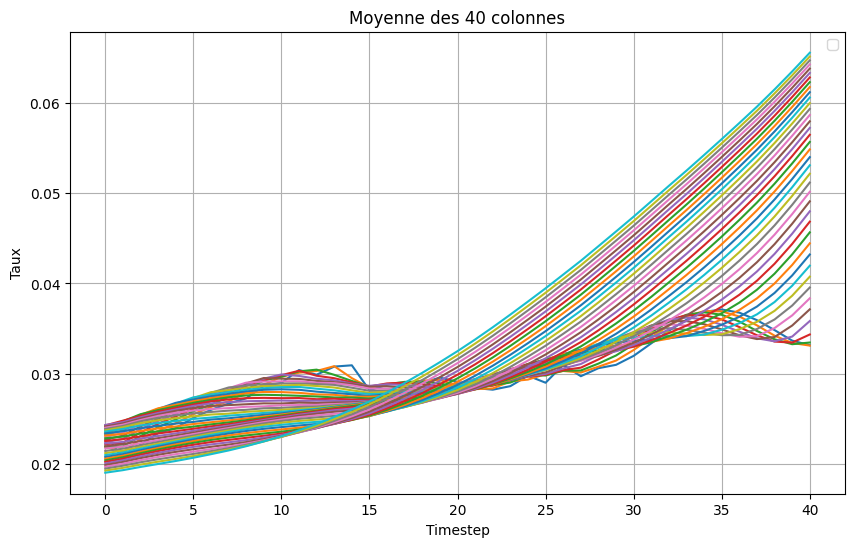

In [4]:
mean_paths = np.mean(Xtrain, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Timestep')
plt.ylabel('Taux')
plt.legend()
plt.grid(True)
plt.show()


# PINN

In [5]:
class GlobalLMMEncoderStable(Model):
    def __init__(self, n_maturities):
        super().__init__()
        self.n = n_maturities

        self.encoder = tf.keras.Sequential([
            layers.Input(shape=(41, self.n)),
            layers.Flatten(),
            layers.Dense(256, activation='relu'),
            layers.Dense(128, activation='relu'),
        ])

        self.sigma_out = layers.Dense(self.n, activation=lambda x: 0.15 + 0.45 * tf.nn.softplus(x))
        self.rho_out = layers.Dense(self.n * (self.n + 1) // 2)

    def call(self, x):  # x: [B, 41, 40]
        z = tf.reduce_mean(self.encoder(x), axis=0, keepdims=True)  # [1, latent]

        # Sigma borné entre 0.05 et 0.5
        sigma = self.sigma_out(z)[0]  # [40]

        # Raw values pour construire L
        raw_corr = self.rho_out(z)[0]
        flat_corr = tf.nn.sigmoid(raw_corr)  # [0, 1]

        # Étape 1 : construire une matrice triangulaire L bornée
        L = tfp.math.fill_triangular(flat_corr)

        # Étape 2 : réduction de la norme pour stabiliser la covariance
        L = L / tf.norm(L)

        # Étape 3 : produire la matrice de corrélation
        cov = tf.matmul(L, L, transpose_b=True)
        d = tf.sqrt(tf.linalg.diag_part(cov))
        corr = cov / (d[:, None] * d[None, :])

        # Sécurité : diagonale fixée à 1.0
        corr = tf.linalg.set_diag(corr, tf.ones(self.n))

        return sigma, corr

In [6]:
def lmm_drift_tf(L, sigma, dt, corr):
    B, n_mat = tf.shape(L)[0], tf.shape(L)[1]
    sigma = tf.reshape(sigma, [1, n_mat])
    sigma_sq = tf.square(sigma)

    drift = tf.zeros_like(L)
    for i in range(n_mat):
        if i + 1 < n_mat:
            L_j = L[:, i+1:]                        # [B, n_j]
            sigma_j = sigma[:, i+1:]                # [1, n_j]
            rho_ij = corr[i, i+1:]                  # [n_j]

            num = sigma[:, i:i+1] * sigma_j * rho_ij * dt * L_j
            denom = 1.0 + dt * L_j
            contrib = tf.reduce_sum(num / denom, axis=1)
            drift_i = -contrib
        else:
            drift_i = tf.zeros([B], dtype=tf.float32)

        drift = tf.tensor_scatter_nd_update(drift, [[j, i] for j in range(B)], drift_i)
    return drift

In [7]:
def lmm_sim_tf_batch(L0_batch, sigma, corr, dt, n_steps):
    B = tf.shape(L0_batch)[0]
    n_mat = tf.shape(L0_batch)[1]
    epsilon = 1e-3
    corr += tf.eye(n_mat) * epsilon
    chol = tf.linalg.cholesky(corr)
    sigma = tf.reshape(sigma, [1, -1])
    sigma_sq = tf.square(sigma)

    all_L = [L0_batch]

    for _ in range(n_steps):
        L_prev = all_L[-1]
        drift = lmm_drift_tf(L_prev, sigma[0], dt, corr)
        Z = tf.random.normal([B, n_mat])
        dW = tf.matmul(Z, tf.transpose(chol)) * tf.sqrt(dt)
        diffusion = dW * sigma
        drift_term = drift - 0.5 * sigma_sq
        update = drift_term * dt + diffusion
        L_next = L_prev * tf.exp(update + 0.05)  # pente artificielle
        all_L.append(L_next)

    return tf.stack(all_L, axis=1)  # [B, n_steps+1, 40]

In [8]:
def lmm_sim_tf_simple(L0, sigma, corr, dt, n_steps, n_sim,pente):
    L0 = tf.convert_to_tensor(L0, dtype=tf.float32)
    sigma = tf.convert_to_tensor(sigma, dtype=tf.float32)
    corr = tf.convert_to_tensor(corr, dtype=tf.float32)

    n_mat = tf.shape(L0)[0]

    # Préparation
    epsilon = 1e-3
    corr += tf.eye(n_mat) * epsilon
    chol = tf.linalg.cholesky(corr)

    all_L = [tf.tile(tf.expand_dims(L0, 0), [n_sim, 1])]  # [n_sim, n_mat]

    for _ in range(n_steps):
        L_prev = all_L[-1]
        drift = lmm_drift_tf(L_prev, sigma, dt, corr)
        Z = tf.random.normal([n_sim, n_mat])
        dW = tf.matmul(Z, tf.transpose(chol)) * tf.sqrt(dt)
        diffusion = dW * sigma
        drift_term = drift - 0.5 * tf.expand_dims(sigma**2, axis=0)
        update = drift_term * dt + diffusion
        L_next = L_prev * tf.exp(update + pente)  # petite pente ajoutée artificiellement

        all_L.append(L_next)

    return tf.stack(all_L, axis=1)  # [n_sim, n_steps+1, n_mat]

In [9]:
def penalty_rho_shape(corr, target=0.2, weight_decay=0.95):
    n = tf.shape(corr)[0]
    i = tf.range(n)
    j = tf.range(n)
    I, J = tf.meshgrid(i, j, indexing='ij')
    dist = tf.abs(I - J)  # distance à la diagonale
    weight = tf.cast(dist, tf.float32)
    weight = tf.pow(weight_decay, weight)

    # On veut corr_ij ≈ target hors diagonale
    mask = tf.cast(tf.not_equal(I, J), tf.float32)
    return tf.reduce_mean(weight * mask * tf.square(corr - target))

In [10]:
def compute_loss_with_model(model, Xbatch, dt=1.0, n_steps=41):
    sigma, corr = model(Xbatch)
    L0_batch = Xbatch[:, 0, :]
    target = Xbatch[:, 1:, :]  # [B, 40, 40]

    sim = lmm_sim_tf_batch(L0_batch, sigma, corr, dt, n_steps)  # [B, 42, 40]
    sim = sim[:, 1:41, :]  # [B, 40, 40]

    loss_mse = tf.reduce_mean(tf.square(sim - target))
    reg_corr = penalty_rho_shape(corr, target=0.2, weight_decay=0.9)

    reg_sigma_smooth = tf.reduce_mean(tf.square(sigma[1:] - sigma[:-1]))

    target_mean = 0.3
    reg_sigma_mean = tf.square(tf.reduce_mean(sigma) - target_mean)

    loss = loss_mse + reg_corr + reg_sigma_smooth + 1e-1 * reg_sigma_mean # lambda à adapter

    return loss

In [11]:
model = GlobalLMMEncoderStable(n_maturities=40)
optimizer = tf.keras.optimizers.Adam(1e-3)
Xtrain_np = Xtrain.numpy() if isinstance(Xtrain, tf.Tensor) else Xtrain

for epoch in range(30):
    idx = np.random.choice(Xtrain_np.shape[0], size=150, replace=False)
    Xsample = tf.convert_to_tensor(Xtrain_np[idx], dtype=tf.float32)

    with tf.GradientTape() as tape:
        loss = compute_loss_with_model(model, Xsample)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    print(f"Epoch {epoch+1}, Loss: {loss.numpy():.6f}")



I0000 00:00:1759407994.661340   69701 cuda_solvers.cc:175] Creating GpuSolver handles for stream 0x559883b433a0


Epoch 1, Loss: 0.140245
Epoch 2, Loss: 0.137414
Epoch 3, Loss: 0.140036
Epoch 4, Loss: 0.137747
Epoch 5, Loss: 0.137519
Epoch 6, Loss: 0.173098
Epoch 7, Loss: 0.136987
Epoch 8, Loss: 0.135017
Epoch 9, Loss: 0.135538
Epoch 10, Loss: 0.133695
Epoch 11, Loss: 0.132554
Epoch 12, Loss: 0.130137
Epoch 13, Loss: 0.127163
Epoch 14, Loss: 0.124564
Epoch 15, Loss: 0.128476
Epoch 16, Loss: 0.121212
Epoch 17, Loss: 0.113292
Epoch 18, Loss: 0.113513
Epoch 19, Loss: 0.097294
Epoch 20, Loss: 0.095979
Epoch 21, Loss: 0.083764
Epoch 22, Loss: 0.076806
Epoch 23, Loss: 0.073083
Epoch 24, Loss: 0.062779
Epoch 25, Loss: 0.062426
Epoch 26, Loss: 0.055121
Epoch 27, Loss: 0.054126
Epoch 28, Loss: 0.052428
Epoch 29, Loss: 0.050594
Epoch 30, Loss: 0.045768


In [12]:
sigma_pred, rho_pred = model(Xtrain)
L0 = Xtrain[0, 0, :]  # shape (n_mat,)
print(rho_pred)
print(sigma_pred)

tf.Tensor(
[[1.         0.64383173 0.09691164 ... 0.06833019 0.11892243 0.15559302]
 [0.64383173 1.         0.24347554 ... 0.05987798 0.09510542 0.20510167]
 [0.09691164 0.24347554 1.         ... 0.01987774 0.08745952 0.14613071]
 ...
 [0.06833019 0.05987798 0.01987774 ... 1.         0.79679793 0.6297111 ]
 [0.11892243 0.09510542 0.08745952 ... 0.79679793 1.         0.72045326]
 [0.15559302 0.20510167 0.14613071 ... 0.6297111  0.72045326 1.        ]], shape=(40, 40), dtype=float32)
tf.Tensor(
[0.19393922 0.20821515 0.23823448 0.23117086 0.29501635 0.28068912
 0.2832601  0.2384103  0.22390692 0.21928632 0.20707716 0.18592498
 0.1857276  0.18105239 0.18085253 0.19229156 0.19212268 0.1872766
 0.19635852 0.20857489 0.18870051 0.18307422 0.17661646 0.17166188
 0.1756026  0.20369774 0.25189516 0.28866485 0.2955388  0.27119046
 0.27790397 0.2904912  0.28021657 0.27734733 0.24610788 0.20764826
 0.1772185  0.1754263  0.15700878 0.15203129], shape=(40,), dtype=float32)


/tmp/ipykernel_69701/365325829.py:26: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


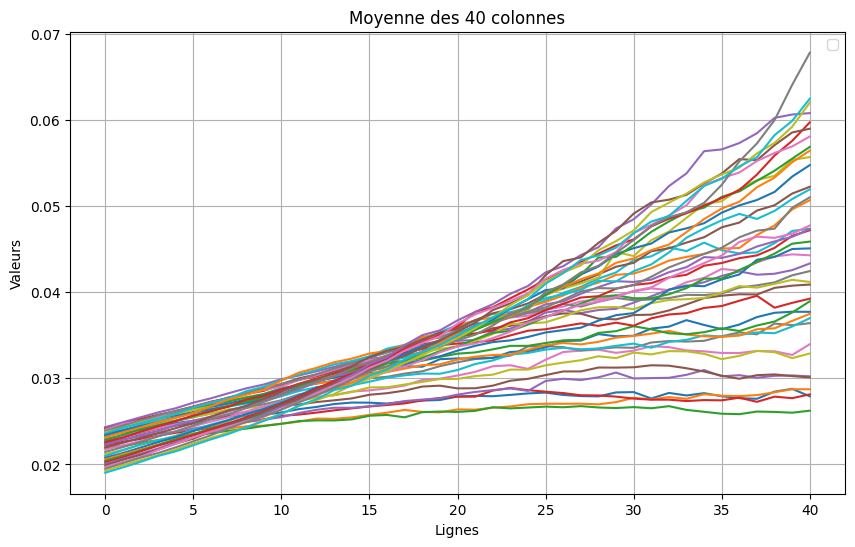

In [14]:
sigma = tf.constant([0.3] * 40, dtype=tf.float32)
rho = tf.constant(0.2 * tf.ones((40, 40)), dtype=tf.float32)
rho = tf.linalg.set_diag(rho, tf.ones(40))

scenarios = lmm_sim_tf_simple(L0, sigma, rho, 1.0, 40, 10000,0.03)

mean_paths = np.mean(scenarios, axis=0)

# Supposons que mean_paths soit de forme (41, 40)
# mean_paths contient les 40 colonnes et 41 valeurs par colonne

plt.figure(figsize=(10, 6))

X=np.arange(41)

# Tracer chaque colonne comme une courbe
for i in range(40):
    Y=[]
    for j in range(41):
        Y.append(mean_paths[j][i])
    plt.plot(X,Y)

plt.title('Moyenne des 40 colonnes')
plt.xlabel('Lignes')
plt.ylabel('Valeurs')
plt.legend()
plt.grid(True)
plt.show()

In [15]:
pente_values = np.linspace(0.01, 0.20, 20)
errors = []
mean_paths_list = []

mean_scenario = np.mean(Xtrain, axis=0)  # [41, 40]

for pente in pente_values:
    sim = lmm_sim_tf_simple(L0, sigma_pred, rho_pred, 1.0, 40, 10000, pente)
    mean_paths = np.mean(sim, axis=0)  # [41, 40]
    mse = np.mean((mean_paths - mean_scenario) ** 2)
    errors.append(mse)
    mean_paths_list.append(mean_paths)

best_idx = int(np.argmin(errors))
best_pente = pente_values[best_idx]
best_error = errors[best_idx]
best_mean_path = mean_paths_list[best_idx]

print(f"Meilleure pente : {best_pente:.5f} avec MSE = {best_error:.6f}")

Meilleure pente : 0.02000 avec MSE = 0.000069
